In [ ]:
import os

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.ticker import MaxNLocator
# Set to LateX
import matplotlib as mpl
mpl.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Computer Modern"],
    "text.latex.preamble": r"\usepackage{amsmath}\usepackage{amsfonts}\usepackage{amssymb}"
})

In [2]:
# Select 2 or 3
dim_problem = 3

In [3]:
# # Prepare to read multiple result files
testname = 'NvsNt1'
base_dir = os.path.abspath(os.path.join(os.getcwd(), ''))
problem_name = f'AdvDiff{dim_problem}D'

/tmp/ipykernel_38557/3251103024.py:154: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


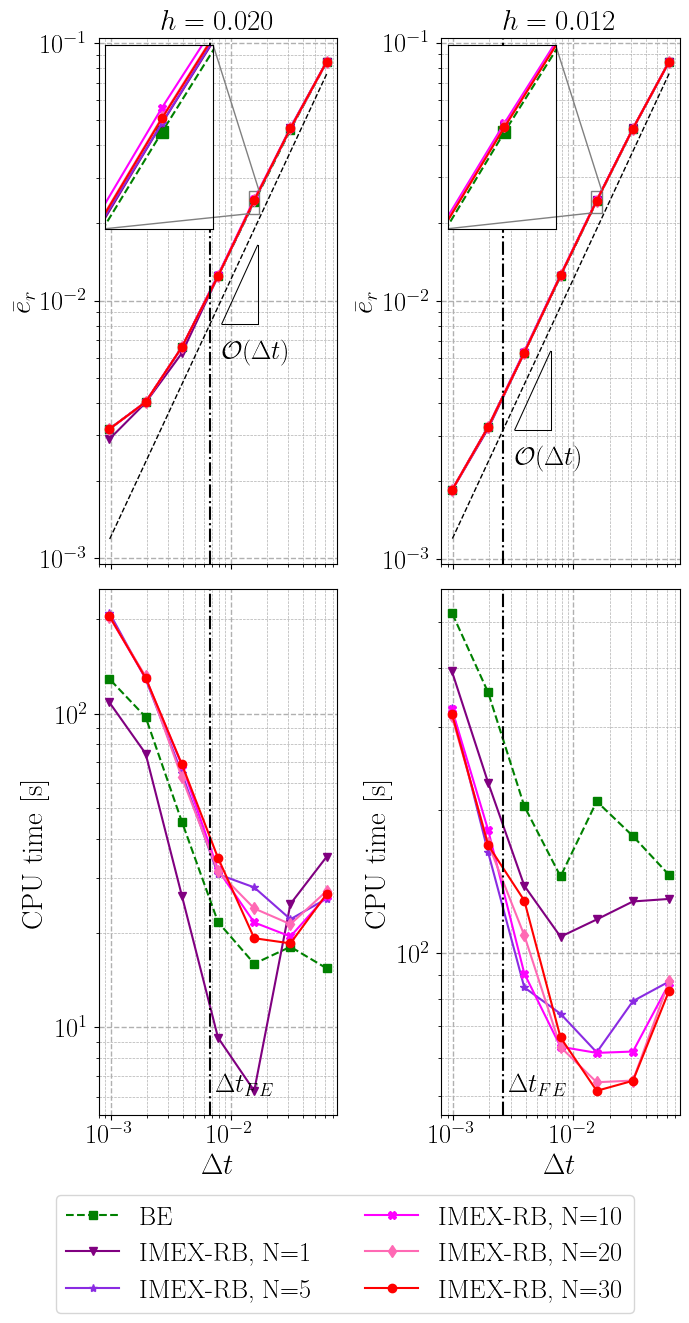

In [4]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes, mark_inset
# Load the single results file which now contains data for all Nx_values
results_path = os.path.join(
    base_dir,
    os.pardir,
    os.pardir,
    "__RESULTS",
    problem_name,
    testname,
    "results.npz",
)

all_markers = ["v", "*", "X", "d", "o", "p", "s", "h"]
all_colors = [
    "purple",
    "blueviolet",
    "magenta",
    "hotpink",
    "red",
    "maroon",
    "teal",
    "orange",
]
larger_fontsize = 21
smaller_fontsize = 19

results = np.load(results_path, allow_pickle=True)
Nx_values = results["Nx_values"]           # array of grid sizes
Ns = results["N_values"]                   # list of RB dimensions
Nts = results["Nt_values"]                 # list of time-step counts
errBE_all = results["errors_l2"].item()["BE"]       # shape: (len(Nts), len(Nx_values))
errIMEX_all = results["errors_l2"].item()["IMEX-RB"]  # shape: (len(Nts), len(Ns), len(Nx_values))
timesBE_all = results["times"].item()["BE"]           # shape: (len(Nts), len(Nx_values))
timesIMEX_all = results["times"].item()["IMEX-RB"]     # shape: (len(Nts), len(Ns), len(Nx_values))
subiters_all = results["subiters"].item()["IMEX-RB"]  # shape: (len(Nts), nIMEX, max_Nt, len(Nx_values))
Nt_FE_all = results["Nt_FE"]                   # array of FE limits

nIMEX = errIMEX_all.shape[1]
all_markers = all_markers[:nIMEX]
all_colors = all_colors[:nIMEX]

xdeltaFE = [1 / Nt_FE * 1.1 for Nt_FE in Nt_FE_all for _ in range(2)]
ydeltaFE = [2e-3, 2e-1, 1.1e-2, 2e0]

fig, axs = plt.subplots(2, 2, figsize=(7, 12), sharex=True)

for col, Nh in enumerate(Nx_values):
    ax_err = axs[0, col]
    ax_err.set_title(rf"$h = {1/Nh:.3f}$", fontsize=larger_fontsize)

    errBE = errBE_all[:, col]
    errIMEX = errIMEX_all[:, :, col]
    timesBE = timesBE_all[:, col]
    timesIMEX = timesIMEX_all[:, :, col]
    Nt_FE = Nt_FE_all[col]

    x_fe = 1 / Nt_FE
    ax_err.loglog(1 / Nts, errBE, "--s", markersize=6,
                  color="green", label="BE")
    for i in range(nIMEX):
        ax_err.loglog(1 / Nts, errIMEX[:, i],
                      f"-{all_markers[i]}", markersize=6,
                      color=all_colors[i],
                      label=f"IMEX-RB, N={Ns[i]}")

    c_ref = Nts[0] * errBE[0] * 0.9
    ax_err.loglog(1 / Nts, c_ref / Nts, "k--", linewidth=1)
    ax_err.axvline(x_fe, color="k", linestyle="-.")
    xmin, xmax = ax_err.get_xlim()
    ymin, ymax = ax_err.get_ylim()
    lxmin, lxmax = np.log10(xmin), np.log10(xmax)
    lymin, lymax = np.log10(ymin), np.log10(ymax)

    fx = 0.05
    lx0 = np.log10(x_fe) + fx * (lxmax - lxmin)
    x0 = 10**lx0
    y_line0 = c_ref * x0
    offset_y = 0.2
    y0 = y_line0 * (1 - offset_y)
    dx_frac = 0.15
    lx_dx = dx_frac * (lxmax - lxmin)
    dx = 10**(lx0 + lx_dx) - x0
    dy = dx

    ax_err.plot([x0, x0 + dx], [y0, y0], "k-", linewidth=0.75)
    ax_err.plot([x0 + dx, x0 + dx], [y0, y0 + dy], "k-", linewidth=0.75)
    ax_err.plot([x0 + dx, x0], [y0 + dy, y0], "k-", linewidth=0.75)
    ax_err.text(x0, y0 - 0.3 * dy, r"$\mathcal{O}(\Delta t)$",
                fontsize=smaller_fontsize, ha="left", va="bottom")

    loc = ("upper left" if col == 0 else "lower right") \
          if dim_problem == 2 else "upper left"
    axins = inset_axes(ax_err, width="45%", height="35%",
                       loc=loc)
    axins.loglog(1 / Nts, errBE, "--s", markersize=8,
                 color="green")
    for i in range(nIMEX):
        axins.loglog(1 / Nts, errIMEX[:, i],
                     f"-{all_markers[i]}", markersize=6,
                     color=all_colors[i])

    focus = 2
    pad = 0.1
    x0_ins = 1 / Nts[focus]
    y0_ins = errBE[focus]
    axins.set_xlim(x0_ins * (1 - pad), x0_ins * (1 + pad))
    axins.set_ylim(y0_ins * (1 - pad), y0_ins * (1 + pad))
    axins.tick_params(
        axis='both', which='both',
        bottom=False, top=False,
        left=False, right=False,
        labelbottom=False, labelleft=False
    )
    mark_inset(ax_err, axins, loc1=1, loc2=3, fc="none", ec="0.5")

    ax_err.grid(which="major", linestyle="--", linewidth=1)
    ax_err.grid(which="minor", linestyle="--", linewidth=0.5)
    ax_err.tick_params(labelsize=smaller_fontsize)
    ax_err.set_ylabel(r"$\bar{e}_r$", fontsize=larger_fontsize)

    ax_time = axs[1, col]
    ax_time.loglog(1 / Nts, timesBE, "--s", markersize=6,
                   color="green", label="BE")
    for i in range(nIMEX):
        ax_time.loglog(1 / Nts, timesIMEX[:, i],
                       f"-{all_markers[i]}", markersize=6,
                       color=all_colors[i],
                       label=f"IMEX-RB, N={Ns[i]}")

    ax_time.axvline(x_fe, color="k", linestyle="-.")
    xmin, xmax = ax_time.get_xlim()
    ymin, ymax = ax_time.get_ylim()
    lxmin, lxmax = np.log10(xmin), np.log10(xmax)
    lymin, lymax = np.log10(ymin), np.log10(ymax)

    f_x, f_y = 0.02, 0.08
    lxfe = np.log10(x_fe)
    x_text = 10**(lxfe + f_x * (lxmax - lxmin))
    y_text = 10**(lymin + f_y * (lymax - lymin))
    ax_time.text(x_text, y_text, r"$\Delta t_{FE}$",
                 fontsize=smaller_fontsize,
                 ha="left", va="top")

    ax_time.grid(which="major", linestyle="--", linewidth=1)
    ax_time.grid(which="minor", linestyle="--", linewidth=0.5)
    ax_time.tick_params(labelsize=smaller_fontsize)
    ax_time.set_xlabel(r"$\Delta t$", fontsize=larger_fontsize)
    ax_time.set_ylabel("CPU time [s]", fontsize=larger_fontsize)

handles, labels = axs[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc="lower center",
           bbox_to_anchor=(0.5, -0.11),
           ncol=2, fontsize=smaller_fontsize)
plt.tight_layout()
plt.savefig(
    os.path.join("plots", f"{problem_name}_convergence_times_N.pdf"),
    bbox_inches="tight",
)

### Process subiterations for a given space discretization
Look at average inner iterations varying $\Delta t$ and iterations over time
for one $\Delta t$

In [5]:
# Read now a single result file, i.e. a single Nx
col = 0 if dim_problem==2 else 1
# Extract data for this grid size
errBE = errBE_all[:, col]
errIMEX = errIMEX_all[:, :, col]
timesBE = timesBE_all[:, col]
timesIMEX = timesIMEX_all[:, :, col]
Nt_FE = Nt_FE_all[col]
subiters = subiters_all[:, :, :, col]
# Masking sub-iterations
mask = np.zeros_like(subiters, dtype=bool)
for i, _Nt in enumerate(Nts):
    mask[i, :, :_Nt] = True
masked_subiters = np.ma.masked_array(subiters, mask=~mask)

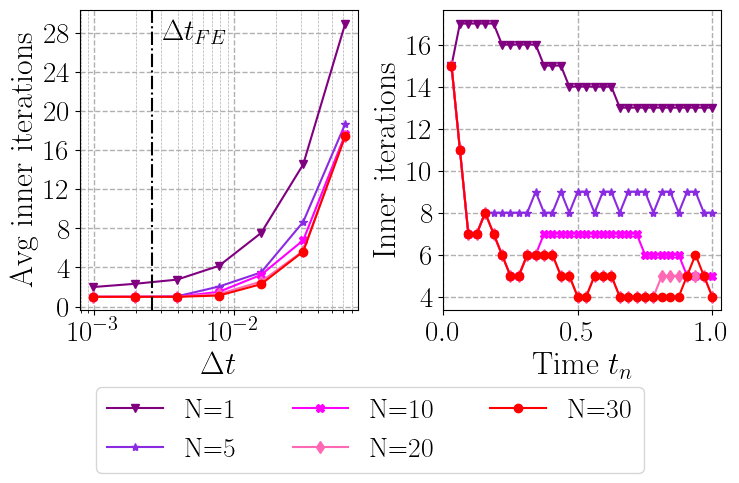

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(7.5, 4))
smaller_fontsize = 21
larger_fontsize = 23
# Left subplot: average inner iterations
ax = axs[0]
for i, (m, c) in enumerate(zip(all_markers, all_colors)):
    mean_iter = np.mean(masked_subiters[:, i] + 1, axis=-1)
    ax.semilogx(
        1 / Nts,
        mean_iter,
        f'-{m}',
        markersize=6,
        color=c,
        label=f"N={Ns[i]}"
    )
ax.axvline(1 / Nt_FE, color='k', linestyle='-.')
ymin, ymax = ax.get_ylim()
ax.text(1 / Nt_FE * 1.2, 0.9*ymax, r"$\Delta t_{FE}$", fontsize=smaller_fontsize, color='k')
ax.grid(which='major', linestyle='--', linewidth=1)
ax.grid(axis='x', which='minor', linestyle='--', linewidth=0.5)
ax.tick_params(axis='both', which='major', labelsize=smaller_fontsize)
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_xlabel(r"$\Delta t$", fontsize=larger_fontsize)
ax.set_ylabel("Avg inner iterations", fontsize=larger_fontsize)

# Right subplot: inner iterations vs time
ax = axs[1]
Nt_idx = 1
tvec = np.linspace(0, 1, Nts[Nt_idx] + 1)[1:]
for i, (m, c) in enumerate(zip(all_markers, all_colors)):
    ax.plot(
        tvec,
        subiters[Nt_idx, i, :Nts[Nt_idx]] + 1,
        f'-{m}',  # use the same marker as in the left plot
        markersize=6,
        color=c,
        label=f"N={Ns[i]}"
    )
ax.grid(which='major', linestyle='--', linewidth=1)
ax.set_xlim([0, 1 + 1 / Nts[Nt_idx]])
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.tick_params(axis='both', which='major', labelsize=smaller_fontsize)
ax.set_xlabel(r"Time $t_n$", fontsize=larger_fontsize)
ax.set_ylabel("Inner iterations", fontsize=larger_fontsize)

# external legend on the right, one column (using legend from the left subplot)
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels,
    loc='lower center',
    bbox_to_anchor=(0.5, -0.23),
    fontsize=smaller_fontsize-1,
    ncol=3
)
plt.tight_layout()
plt.savefig('plots/' + f'{problem_name}_' + f'iters_N_Nx_{Nx_values[col]}.pdf', bbox_inches="tight")
